In [98]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [106]:
chicago = pd.read_csv("prepared_data.csv", parse_dates=["start_time","end_time"])
#add month, day, hour
chicago["month"] = chicago["start_time"].apply(lambda x: x.month)
chicago["day"] = chicago["start_time"].apply(lambda x: x.day)
chicago["hour"] = chicago["start_time"].apply(lambda x: x.hour)
chicago["duration"] = (chicago["end_time"] - chicago["start_time"]).astype("timedelta64[m]")
chicago.head(1)

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,duration,month,day,hour
0,0,2016-03-31 23:53:00,2016-04-01 00:07:00,344,458,Ravenswood Ave & Lawrence Ave,Broadway & Thorndale Ave,155,Subscriber,14.0,3,31,23


In [107]:
chicago_m = chicago[chicago['month']==6]
print(chicago['start_time'].size)
print(chicago_m['start_time'].size)

3586330
476883


In [108]:
#get weather
weather = pd.read_csv("weather_hourly_chicago.csv",parse_dates = ["date_time"])
#only keep 2016 data
weather = weather[weather["date_time"].apply(lambda x:x.year == 2016)]
weather = weather.dropna()
#add month, day, hour
weather["month"] = weather["date_time"].apply(lambda x:x.month)
weather["day"] = weather["date_time"].apply(lambda x:x.day)
weather["hour"] = weather["date_time"].apply(lambda x:x.hour)
weather.sort_values(by="date_time")
weather.head(1)

,date_time,max_temp,min_temp,precip,month,day,hour
8736,2016-01-01 01:00:00,-5.0,-5.0,0.0,1,1,1


In [111]:
#merge weather and bikesharing data
all_data = chicago_m.merge(weather[["max_temp","min_temp","precip","month","day","hour"]],left_on=["month","day","hour"],right_on=["month","day","hour"])
all_data.head(1)

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,duration,month,day,hour,max_temp,min_temp,precip
0,991867,2016-06-30 23:59:00,2016-07-01 00:02:00,93,113,Sheffield Ave & Willow St,Bissell St & Armitage Ave,1508,Subscriber,3.0,6,30,23,24.4,24.4,0.0


In [112]:
relevant_columns = all_data[["start_time","month","day","hour","duration","max_temp","precip","bike_id"]]
# aggregate the samples into hourly chunks
relevant_columns = all_data[["start_time","month","day","hour","duration","max_temp","precip","bike_id"]]
feature_data = relevant_columns.groupby(pd.Grouper(key='start_time',freq='1H')).agg({"month":"mean","day":"mean","hour":"mean","duration":"mean","max_temp":"mean","precip":"mean","bike_id":"count"})
feature_data.rename(columns={"duration":"mean_duration","bike_id":"trips"}, inplace=True)
# deal with null values
feature_data.loc[feature_data["month"].isna(),"month"] = feature_data.index.to_series().apply(lambda x: x.month)
feature_data.loc[feature_data["day"].isna(),"day"] = feature_data.index.to_series().apply(lambda x: x.day)
feature_data.loc[feature_data["hour"].isna(),"hour"] = feature_data.index.to_series().apply(lambda x: x.hour)
feature_data = feature_data.fillna(method="ffill")
feature_data.head(1)

,month,day,hour,mean_duration,max_temp,precip,trips
start_time,,,,,,,
2016-06-01,6.0,1.0,0.0,13.18,19.4,0.0,50


In [113]:
feature_data["isWeekday"] = feature_data.index.to_series().apply(lambda x: 1 if x.dayofweek in [5,6] else 0)

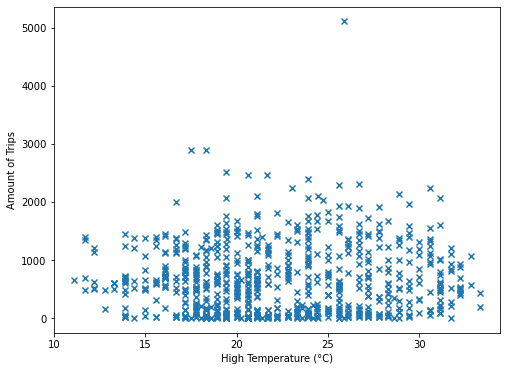

In [120]:
Xp = feature_data["max_temp"].values
Yp = feature_data["trips"].values
plt.figure(figsize = (8,6))
plt.scatter(Xp, Yp, marker="x")
plt.xlabel("High Temperature (°C)")
plt.ylabel("Amount of Trips")
plt.show()

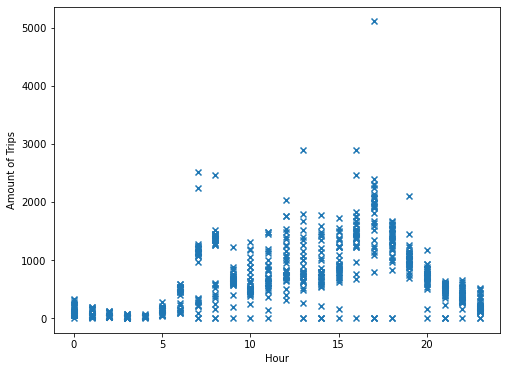

In [167]:
Xp = feature_data["hour"]
Yp = feature_data["trips"].values
plt.figure(figsize = (8,6))
plt.scatter(Xp, Yp, marker="x")
plt.xlabel("Hour")
plt.ylabel("Amount of Trips")
plt.show()

In [168]:
#Xp = feature_data[["month","day","hour","max_temp","precip","isWeekday"]]
Yp = feature_data["trips"].values
#scaler = StandardScaler()
#Xp_sc = scaler.fit_transform(Xp)
Xp = feature_data["max_temp"].values.reshape([-1,1])

In [173]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def plot_tree_regression_line(tree_depth):

    # Fit regression model (to full data)
    Tree_reg = DecisionTreeRegressor(max_depth=tree_depth,criterion="mse")
    Tree_reg.fit(Xp , Yp) 
    
    attributes = Tree_reg.tree_

    # plot
    plt.figure(figsize = (8,6))
    plt.scatter(Xp, Yp, marker="x")
    plt.plot(np.arange(10,35,1), Tree_reg.predict(np.arange(10,35,1).reshape((-1,1))), marker="x", color='C1')
    plt.xlabel("High Temperature (°C)", fontsize=16)
    plt.ylabel("Peak Demand (GW)", fontsize=16)
    
    print("number of nodes: ", attributes.node_count)
    print("number of leafs: ", attributes.n_leaves)
    
    #plt.savefig("Peak_Power_Regression_Lines_{}depth.pdf".format(tree_depth))

number of nodes:  109
number of leafs:  55


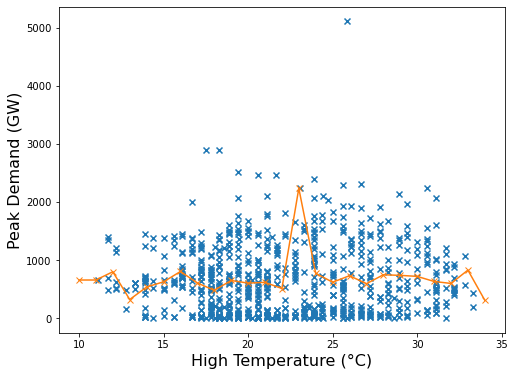

In [174]:
plot_tree_regression_line(50)

In [182]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz

def plot_regression_tree_sklearn(tree_depth):

    # Fit regression model (to full data)
    model = DecisionTreeRegressor(max_depth=tree_depth)
    model.fit(Xp, Yp) 
    
    dot_data = export_graphviz(model,
                              feature_names=["High_temp"])  
    
    graph = graphviz.Source(dot_data) 
    
    return graph

ModuleNotFoundError: No module named 'graphviz'

In [183]:
plot_regression_tree_sklearn(3)

NameError: name 'graphviz' is not defined